<a href="https://colab.research.google.com/github/pratik-poudel/financial_news_stock/blob/master/3%20Classification%20index%200.71%20with%20neg-neu-pos%20all%20final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!pip install mlxtend --upgrade

Requirement already up-to-date: mlxtend in /usr/local/lib/python3.7/dist-packages (0.18.0)


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional,LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.utils import to_categorical, plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score,precision_recall_fscore_support
from sklearn.utils import resample, shuffle


from mlxtend.plotting import plot_confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

# Financial Phrase Bank 

In [ ]:
dj_data = pd.read_csv()

In [3]:
fin_data = pd.read_table('/content/Sentences_50Agree.txt', delimiter='\r\n')

In [4]:
values = np.array([fin_data.values[i][0].split('@') for i in range(fin_data.shape[0])])
data = pd.DataFrame({'sentence': values[:, 0], 'sentiment':values[:, 1]})

In [5]:
data.head(2)

,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative


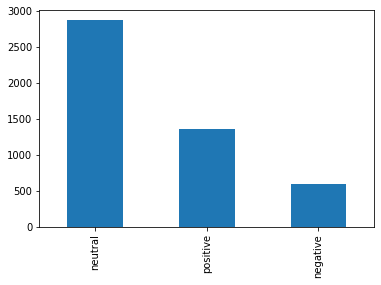

In [6]:
data['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [7]:
X= data.sentence
y = data.sentiment
# neu = y[y == 'neutral'].index
# X= X.drop(neu)
# y = y.drop(neu)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=60, test_size=0.2)

In [8]:
X_train.shape, X_test.shape, X.shape

((3876,), (969,), (4845,))

In [9]:
neu_index = y_train[y_train == 'neutral'].index
pos_index = y_train[y_train == 'positive'].index
neg_index = y_train[y_train == 'negative'].index

In [10]:

# Down-sample neutral class
X_train_neu, y_train_neu = resample(X_train.loc[neu_index], y_train.loc[neu_index],
                                    n_samples=len(pos_index), replace=False,
                                    random_state=60)

# Up-sample negative class
X_train_neg, y_train_neg = resample(X_train.loc[neg_index], y_train.loc[neg_index],
                                    n_samples=len(pos_index), replace=True,
                                    random_state=60)

In [11]:
# Combine resampled classes
X_train_resample = X_train.loc[pos_index].append([X_train_neu, X_train_neg])
y_train_resample = y_train.loc[pos_index].append([y_train_neu, y_train_neg])

# Shuffle samples
X_train_resample, y_train_resample = shuffle(X_train_resample, y_train_resample, random_state=7)

# Display new class counts
print(y_train_resample.value_counts())

neutral     1090
positive    1090
negative    1090
Name: sentiment, dtype: int64


In [ ]:
# X_train = X_train.loc[pos_index].append(X_train_neg)
# y_train = y_train.loc[pos_index].append(y_train_neg)
# X_train, y_train = shuffle(X_train, y_train, random_state=60)

In [12]:
y_test.value_counts()

neutral     575
positive    273
negative    121
Name: sentiment, dtype: int64

In [13]:
X_train_resample.shape, y_train_resample.shape

((3270,), (3270,))

# Prepare Data for model

In [14]:
# Remove Punctuation and assign integer to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_resample)
X_train_seq = tokenizer.texts_to_sequences(X_train_resample)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [15]:
# Make sequences of equal length 
max_len = np.max([len(X_train_seq[i]) for i in range(len(X_train_seq))])
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)

In [16]:
X_train_seq.shape

(3270, 71)

In [17]:
# Convert sentiment values to one hot encoded for Keras model
le = LabelEncoder()
le.fit(y_train_resample)
y_train_seq = to_categorical(le.transform(y_train_resample))
y_test_seq = to_categorical(le.transform(y_test))

In [18]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

# EMBEDDINGS

In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-03-25 07:17:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-25 07:17:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-25 07:17:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
list(model.wv.vocab)

In [ ]:
model.most_similar(positive='pokhara')

In [ ]:
model.most_similar('stock')

In [20]:
dict_w2v = {}
with open('/content/glove.6B.100d.txt', 'r') as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 100:
            dict_w2v[word] = vector
        else:
            print("There is issue with " + word)

In [21]:
print("dictionary size :" ,len(dict_w2v) )

dictionary size : 400000


In [41]:
words_found = set()
words_not_found = set()
for word in tokenizer.word_index:
    vec = dict_w2v.get(word)
    if vec is not None:
        words_found.add(word)
    else:
        words_not_found.add(word)
len(words_found), len(words_not_found), len(tokenizer.word_index)

(6187, 918, 7105)

In [42]:
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index)
embedding_matrix = np.zeros((VOCAB_SIZE +1, EMBEDDING_DIM))

In [43]:
unk_cnt = 0
unk_set = set()
for word, i in tokenizer.word_index.items():
    emb_vector = dict_w2v.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
unk_cnt

918

In [44]:
X_train_seq.shape, y_train_seq.shape

((3270, 71), (3270, 3))

# Training

Epoch 1/100
52/52 [==============================] - 7s 81ms/step - loss: 1.1034 - recall: 0.1920 - val_loss: 0.8476 - val_recall: 0.4747
Epoch 2/100
52/52 [==============================] - 1s 17ms/step - loss: 0.9179 - recall: 0.3781 - val_loss: 0.8308 - val_recall: 0.4365
Epoch 3/100
52/52 [==============================] - 1s 17ms/step - loss: 0.8344 - recall: 0.4765 - val_loss: 0.8450 - val_recall: 0.4809
Epoch 4/100
52/52 [==============================] - 1s 17ms/step - loss: 0.7715 - recall: 0.5589 - val_loss: 0.7288 - val_recall: 0.6047
Epoch 5/100
52/52 [==============================] - 1s 17ms/step - loss: 0.7135 - recall: 0.5985 - val_loss: 0.7391 - val_recall: 0.5944
Epoch 6/100
52/52 [==============================] - 1s 17ms/step - loss: 0.6730 - recall: 0.6435 - val_loss: 0.6557 - val_recall: 0.6574
Epoch 7/100
52/52 [==============================] - 1s 17ms/step - loss: 0.6155 - recall: 0.6920 - val_loss: 0.6316 - val_recall: 0.6780
Epoch 8/100
52/52 [===============

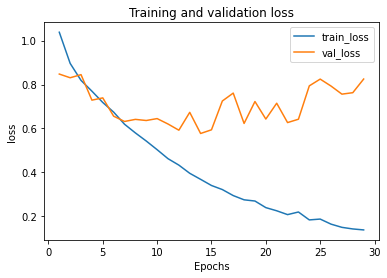

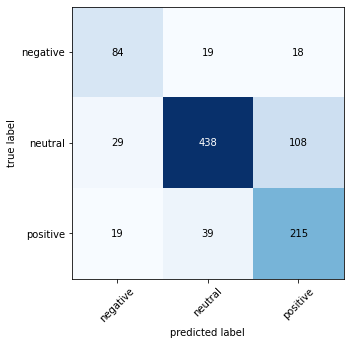

          1-Precision  2-Recall  3-F1 score  4-Support
negative  0.636        0.694     0.664       121      
neutral   0.883        0.762     0.818       575      
positive  0.630        0.788     0.700       273      


In [215]:
np.random.seed(60)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(VOCAB_SIZE +1, EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_len, trainable=False))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat')) #{"sum", "mul", "ave", "concat", None}
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[ 
                                                                            #  'Precision',                                                        
                                                                             'Recall',
                                                                            #  'accuracy'
                                                                             ])
# model.summary()

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')


batch_size = 64
epochs = 100


history = model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size,verbose=1, validation_data=(X_test_seq, y_test_seq), 
                    callbacks=[early_stopping, mcp_save], shuffle=False)


%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')


model.load_weights('model.hdf5')

preds = model.predict(X_test_seq, batch_size=batch_size)
true_y = np.argmax(y_test_seq, axis=1)
pred_y = np.argmax(preds, axis=1)

c_mat = confusion_matrix(true_y, pred_y)
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

p, r, f1, s = precision_recall_fscore_support(true_y, pred_y, average=None)

# Print precision, recall, f1 score and support
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))

# Prepare NEPSE DATA

In [9]:
indices = pd.read_csv('/content/Nepse Indices - Sheet1.csv', header=1)
indices.columns= ['no_name', 'date', 'index', 'abs_change', 'pct_change']
indices['date'] = pd.to_datetime(indices['date'])
indices = indices[indices['date'] < '2019-07-06']

In [10]:
news_df = pd.read_csv('/content/years_combined_df.csv')
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df[news_df['date'] >= '2014-02-02']
news_df.reset_index(drop=True, inplace=True)
print("Total News Data Scraped :", news_df.shape[0])

Total News Data Scraped : 9802


In [11]:
news_df = news_df[news_df['date'].isin(indices['date'])].reset_index(drop=True)
print("Total News Data as per Nepse indices trading days ", news_df.shape[0])

Total News Data as per Nepse indices trading days  6307


In [12]:
print("Total NEPSE Index days: ", indices.shape[0])

Total NEPSE Index days:  1248


In [13]:
indices = indices[indices['date'].isin(news_df['date'])].reset_index(drop=True)
print("Total NEPSE index matched with News date:", indices.shape[0])

Total NEPSE index matched with News date: 1238


In [14]:
indices['pct_change'] = indices['pct_change'].str.replace('%', '').astype(float)

In [15]:
indices['target'] = np.where(indices['pct_change'] < 0 , 0, 1)

In [223]:
def prepare_and_predict_news(series, pad_max_len, batch_size):

    news = tokenizer.texts_to_sequences(series)
    news = pad_sequences(news, pad_max_len)
    news = model.predict(news, batch_size=batch_size)
    return news

In [224]:
news_sentiment = prepare_and_predict_news(news_df['content'], pad_max_len=max_len, batch_size=batch_size)
# news_df['pred_glove_300'] = np.argmax(news_sentiment, axis=1)

In [225]:
news_sentiment_df = pd.DataFrame(news_sentiment, columns=le.classes_)

In [226]:
final_df = pd.concat([news_df, news_sentiment_df], axis=1)

In [227]:
# pd.set_option('max_colwidth', -1)
# final_df[['content', 'negative', 'neutral','positive']].head(15)

In [228]:
df = pd.merge(final_df, indices, left_on='date', right_on='date')

In [229]:
df.to_csv('final-df.csv', index=False)

In [52]:
import pandas as pd
import numpy as np
df = pd.read_csv('final-df.csv')

In [53]:
indices['negative_mean'] = df.groupby('date')['negative'].apply(np.mean).reset_index(drop=True)
indices['neutral_mean'] = df.groupby('date')['neutral'].apply(np.mean).reset_index(drop=True)
indices['positive_mean'] = df.groupby('date')['positive'].apply(np.mean).reset_index(drop=True)

In [54]:
features = ['negative_mean', 'neutral_mean','positive_mean']

In [55]:
validation_df = indices[indices['date'] > '2018-12-31']
train_df = indices[indices['date'] <= '2018-12-31']

In [56]:
Xtrain, ytrain = train_df[features], train_df['target']

In [57]:
Xtest, ytest = validation_df[features], validation_df['target']

In [58]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((1117, 3), (1117,), (121, 3), (121,))

In [59]:
def accuracy_metrics(preds, dtrain):
    labels = dtrain.get_label()

    preds = np.round(preds)
    acc_score = accuracy_score(labels, preds)
    return 'acc_score', acc_score, True

In [49]:
# ax = lgb.plot_metric(evals_result, metric='binary_logloss')
# plt.show()

In [238]:
# !pip install optuna

In [62]:
import optuna
from sklearn.metrics import roc_auc_score
from google.colab import output
tr_data = lgb.Dataset(Xtrain, ytrain)
va_data = lgb.Dataset(Xtest, ytest)
def objective(trial):    
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 2, 512),
            'boosting_type': 'gbdt',
            'objective': 'binary',
            # 'metric': 'auc',
            'bagging_seed':60,
            'max_depth': trial.suggest_int('max_depth', 1, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 80),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
            'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'max_bin': trial.suggest_int('max_bin', 4, 900),
            'early_stopping_rounds': 50,
            'random_state':60 
            }

    model = lgb.train(params, tr_data, valid_sets=[tr_data, va_data], verbose_eval=None, num_boost_round=5000, feval=accuracy_metrics)
    score = model.best_score['valid_1']['acc_score']
    # val_pred = model.predict(Xtest)
    # score = accuracy_score(ytest, np.round(val_pred))
    # print(score)
    output.clear()
    # print(f"AUC = {score}")
    return score



In [63]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2021-03-25 09:46:25,686] Trial 499 finished with value: 0.5950413223140496 and parameters: {'num_leaves': 462, 'max_depth': 7, 'min_child_weight': 4, 'feature_fraction': 0.6593877856243415, 'bagging_fraction': 0.6731278782352519, 'bagging_freq': 3, 'min_child_samples': 67, 'lambda_l1': 1.0341294536606787e-06, 'lambda_l2': 0.000290271715241382, 'learning_rate': 0.8947748533763338, 'max_bin': 553}. Best is trial 138 with value: 0.7024793388429752.


In [67]:
study.best_params

{'bagging_fraction': 0.6506480465023792,
 'bagging_freq': 4,
 'feature_fraction': 0.6750931201345176,
 'lambda_l1': 6.659723571830545e-06,
 'lambda_l2': 7.171849219399176e-05,
 'learning_rate': 0.6707680192278893,
 'max_bin': 563,
 'max_depth': 15,
 'min_child_samples': 64,
 'min_child_weight': 13,
 'num_leaves': 428}

In [68]:

import lightgbm as lgb
# tr_data = lgb.Dataset(Xtrain, label=ytrain)
# va_data = lgb.Dataset(Xtest, label=ytest)
params = {
'objective': 'binary',
"boosting_type": "gbdt",
"verbosity": -1,
'random_state': 60,
'bagging_seed':60,

'bagging_fraction': 0.6506480465023792,
 'bagging_freq': 4,
 'feature_fraction': 0.6750931201345176,
 'lambda_l1': 6.659723571830545e-06,
 'lambda_l2': 7.171849219399176e-05,
 'learning_rate': 0.6707680192278893,
 'max_bin': 563,
 'max_depth': 15,
 'min_child_samples': 64,
 'min_child_weight': 13,
 'num_leaves': 428
}

evals_result = {}
model = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,   
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,   
        feature_name=features,
        verbose_eval=10, 
        feval = accuracy_metrics, 
        evals_result = evals_result
    )

Training until validation scores don't improve for 50 rounds
[10]	training's binary_logloss: 0.650647	training's acc_score: 0.618621	valid_1's binary_logloss: 0.663819	valid_1's acc_score: 0.570248
[20]	training's binary_logloss: 0.624328	training's acc_score: 0.632945	valid_1's binary_logloss: 0.671444	valid_1's acc_score: 0.586777
[30]	training's binary_logloss: 0.594659	training's acc_score: 0.680394	valid_1's binary_logloss: 0.663631	valid_1's acc_score: 0.661157
[40]	training's binary_logloss: 0.579745	training's acc_score: 0.692927	valid_1's binary_logloss: 0.650653	valid_1's acc_score: 0.661157
[50]	training's binary_logloss: 0.559162	training's acc_score: 0.717995	valid_1's binary_logloss: 0.668746	valid_1's acc_score: 0.628099
[60]	training's binary_logloss: 0.539209	training's acc_score: 0.726947	valid_1's binary_logloss: 0.648434	valid_1's acc_score: 0.661157
[70]	training's binary_logloss: 0.52444	training's acc_score: 0.750224	valid_1's binary_logloss: 0.645921	valid_1's a

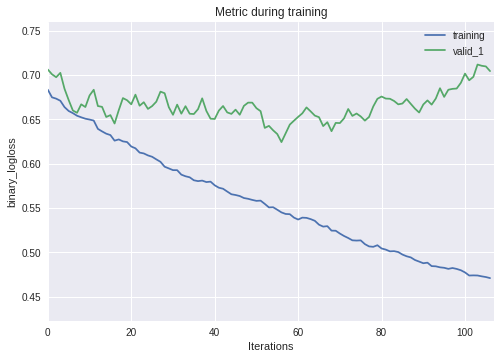

In [99]:
import matplotlib.pyplot as plt

lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()

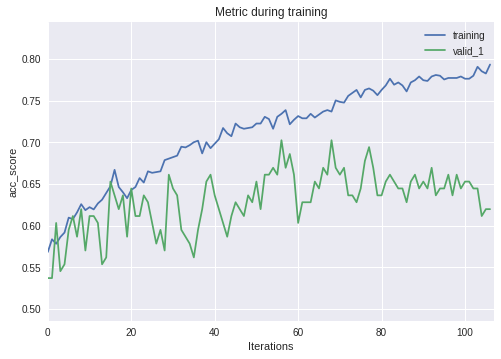

In [100]:
lgb.plot_metric(evals_result, metric='acc_score')
plt.show()

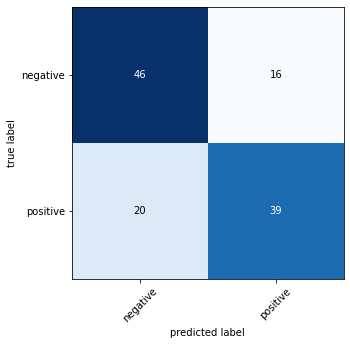

          Precision  Recall  F1 score  Support
negative       0.70    0.74      0.72       62
positive       0.71    0.66      0.68       59
0.7161016949152543
0.7024793388429752


In [78]:
preds = model.predict(Xtest, model.best_iteration)
c_mat = confusion_matrix(ytest, np.round(preds))
plot_confusion_matrix(c_mat, cmap='Blues', class_names = ['negative', 'positive'], figsize=(5, 5))
plt.show()

p, r, f1, s = precision_recall_fscore_support(ytest, np.round(preds), average=None)

results = pd.DataFrame({'Precision': p, 'Recall': r, 'F1 score': f1, 'Support': s}, index=['negative', 'positive'])
print(results.round(decimals=3))
print(roc_auc_score(ytest, preds))
print(accuracy_score(ytest, np.round(preds)))

In [95]:
fpr, tpr, thresholds = roc_curve(ytest, model.predict(Xtest))
random_probs = [0 for i in range(len(ytest))]
p_fpr, p_tpr, _ = roc_curve(ytest, random_probs, pos_label=1)

In [88]:
from sklearn.metrics import plot_roc_curve

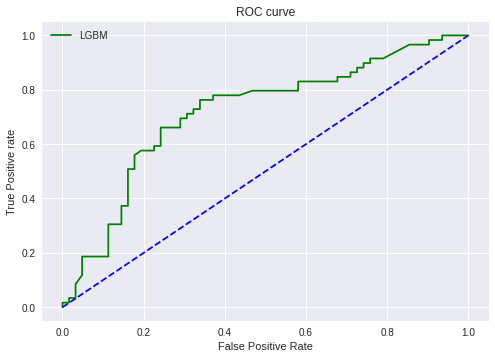

In [98]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr, tpr, linestyle='-',color='green', label='LGBM')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
thresholds

In [ ]:
# !pip install lazypredict
from lazypredict.Supervised import LazyClassifier

In [24]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

In [25]:
models,predictions = clf.fit(Xtrain, Xtest, ytrain, ytest)
models

100%|██████████| 29/29 [00:01<00:00, 22.12it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.63,0.63,0.63,0.63,0.08
KNeighborsClassifier,0.61,0.61,0.61,0.61,0.01
SVC,0.60,0.60,0.60,0.60,0.05
BernoulliNB,0.60,0.59,0.59,0.58,0.01
LabelSpreading,0.59,0.59,0.59,0.59,0.08
LabelPropagation,0.59,0.59,0.59,0.59,0.06
RandomForestClassifier,0.59,0.59,0.59,0.59,0.24
AdaBoostClassifier,0.59,0.59,0.59,0.59,0.10
SGDClassifier,0.59,0.58,0.58,0.57,0.01


In [47]:
pd.DataFrame(models).reset_index()

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,LGBMClassifier,0.63,0.63,0.63,0.63,0.08
1,KNeighborsClassifier,0.61,0.61,0.61,0.61,0.01
2,SVC,0.60,0.60,0.60,0.60,0.05
3,BernoulliNB,0.60,0.59,0.59,0.58,0.01
4,LabelSpreading,0.59,0.59,0.59,0.59,0.08
5,LabelPropagation,0.59,0.59,0.59,0.59,0.06
6,RandomForestClassifier,0.59,0.59,0.59,0.59,0.24
7,AdaBoostClassifier,0.59,0.59,0.59,0.59,0.10
8,SGDClassifier,0.59,0.58,0.58,0.57,0.01
9,ExtraTreesClassifier,0.58,0.58,0.58,0.58,0.16
